# Dataloaders

In [1]:
# Importing libraries
import torchio as tio
import glob
import numpy as np
import random
import os

from collections import OrderedDict
from pathlib import Path

from tqdm import tqdm
import time

import torchio as tio
from torchio.transforms import (RescaleIntensity,RandomFlip,Compose, HistogramStandardization)

from torch.utils.data import DataLoader
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

In [20]:
# Define dictionary describing assignment of participants to the groups

# Groups
train_groups=['HCP']

# Dictionary with study design
design = {}
design['train']={}


# Training data
for group in train_groups:

    # Idices of all subjects
    ids=[os.path.basename(path) for path in glob.glob('../../../1_Data/1_Input/HCP/100307/*')]      

    path_to_folder='../../../1_Data/1_Input/HCP/100307/'

    files={}
    files['brain']=path_to_folder+'t1w_1mm_iso.nii.gz'
    files['probs']=path_to_folder+'sampling_distribution.nii.gz'
    files['chiasm']=path_to_folder+'chiasm.nii.gz'

    design['train']=files

 

In [21]:
design

{'train': {'brain': '../../../1_Data/1_Input/HCP/100307/t1w_1mm_iso.nii.gz',
  'probs': '../../../1_Data/1_Input/HCP/100307/sampling_distribution.nii.gz',
  'chiasm': '../../../1_Data/1_Input/HCP/100307/chiasm.nii.gz'}}

In [22]:
# Dictionary with all images
subjects_list = {'train': [tio.Subject(
                            t1=tio.Image(design['train']['brain'], type=tio.INTENSITY),
                            probs = tio.Image(design['train']['probs'], type = tio.INTENSITY))]}

In [23]:
# Rescale
rescale = RescaleIntensity((0,1))

transform_train = Compose([rescale]) # leaving out standardization for now


In [24]:
# Torchio's (Pytorch's) Dataset
dataset = {'train': tio.SubjectsDataset(subjects_list['train'], transform=transform_train)}

In [25]:
# Sampler
patch_size = (24,24,8)
queue_length = 600
samples_per_volume = 20

sampler = tio.data.WeightedSampler(patch_size,'probs')

In [26]:
# Dataloader
dataloader={'train': DataLoader( tio.Queue(dataset['train'], queue_length, samples_per_volume, sampler, num_workers=8), batch_size = 10)}

In [57]:
# Create dataloader for images of the chiasm exclusively

# Dictionary with all chiasm images
subjects_chiasms_list = {'train': [tio.Subject(t1=tio.Image(design['train']['chiasm'], type=tio.INTENSITY))]}

# Dataset containing only chiasm images
dataset_chiasms = {'train': tio.SubjectsDataset(subjects_chiasms_list['train'], transform = Compose([rescale]))}

# Standard dataloader with images of chiasm
# Dataloader
dataloader_chiasms={'train': DataLoader(dataset=dataset_chiasms['train'], batch_size = 10, shuffle=True, num_workers =8)}

# Network and parameters

In [29]:
# Try setting CUDA if possible
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu") 
    
print(device)

cuda


In [30]:
# U-Net architecture

class UNet(nn.Module):
    
    def __init__(self, in_channels=1, out_channels=1, init_features=10, scaling=2):
        super(UNet, self).__init__()
                
        # Encoding layers
        self.encoder1 = self.unet_block(in_channels, init_features, "enc1")
        self.pool1 = nn.AvgPool3d(kernel_size=2, stride=2, padding=0)
        self.encoder2 = self.unet_block(init_features, init_features*scaling, name='enc2')
        self.pool2 = nn.AvgPool3d(kernel_size=2, stride=2, padding=0)

        # Bottleneck layer
        self.bottleneck = self.unet_block(init_features*scaling, init_features*scaling**2, name='bottleneck')
        
        # Decoding layers (where merge with prevois encoding layers occurs)        
        self.upconv2 = nn.ConvTranspose3d(init_features*scaling**2, init_features*scaling, kernel_size=2, stride=2)
        self.decoder2 = self.unet_block(init_features*scaling, init_features*scaling, name='dec2')
                
        self.upconv1 = nn.ConvTranspose3d(init_features*scaling, init_features, kernel_size=2, stride=2)
        self.decoder1 = self.unet_block(init_features, init_features, name='dec1')
        
        # Final convolution - output equals number of output channels
        self.conv = nn.Conv3d(init_features, out_channels, kernel_size=1) 
        
    def forward(self,x):
        
        # Encoding
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool2(enc2))

        # Upconvolving, concatenating data from respective encoding phase and executing UNet block
        dec2 = self.upconv2(bottleneck)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = self.decoder1(dec1)
        
        out_conv = self.conv(dec1)
        
        return torch.sigmoid(out_conv)
    
    def unet_block(self, in_channels, features, name):
        
        return nn.Sequential(OrderedDict([(name+'conv1',nn.Conv3d(in_channels=in_channels, out_channels=features, kernel_size=3, padding=1, bias=False)),
                             (name+'bnorm1', nn.BatchNorm3d(num_features=features)),
                             (name+'relu1', nn.ReLU(inplace=True)),
                             (name+'conv2', nn.Conv3d(in_channels=features, out_channels=features, kernel_size=3, padding=1, bias=False)),
                             (name+'bnorm2', nn.BatchNorm3d(num_features=features)),
                             (name+'relu2', nn.ReLU(inplace=True))])
                            )

    def output_latent_representations(self,x):
        
        print(x.shape)

        # Encoding
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool2(enc2))
        
        print(bottleneck.shape)
        
        return bottleneck

In [31]:
# 4,2 looks so far best on the brain, chiasm suboptimal - 4*2**2 = 16 -> compression 16/64
# 4,4 greatly reconstructs the brain, but is mediocre on the chiasm -> compression 1/1

# increasing number of initial layers help greatly

# Try different init_features and scaling + activation function for an output

#unet = UNet(1,1,4,4)
#unet.to(device)

In [41]:
# U-Net architecture

class UNet(nn.Module):
    
    def __init__(self, in_channels=1, out_channels=1, init_features=64, scaling=2):
        super(UNet, self).__init__()
                
        # Encoding layers
        self.encoder1 = self.unet_block(in_channels, init_features, "enc1")
        self.pool1 = nn.AvgPool3d(kernel_size=2, stride=2, padding=0)

        # Bottleneck layer
        self.bottleneck = self.unet_block(init_features, int(init_features/(scaling)), name='bottleneck')
        
        # Decoding layers (where merge with prevois encoding layers occurs)        
       
        self.upconv1 = nn.ConvTranspose3d(int(init_features/scaling), init_features, kernel_size=2, stride=2)
        self.decoder1 = self.unet_block(init_features, init_features, name='dec1')
        
        # Final convolution - output equals number of output channels
        self.conv = nn.Conv3d(init_features, out_channels, kernel_size=1) 
        
    def forward(self,x):
        
        # Encoding
        enc1 = self.encoder1(x)
        
        # Bottleneck
        bottleneck = self.bottleneck(self.pool1(enc1))
        
        # Upconvolving, concatenating data from respective encoding phase and executing UNet block
        dec1 = self.upconv1(bottleneck)
        dec1 = self.decoder1(dec1)
        
        out_conv = self.conv(dec1)
        
        return torch.sigmoid(out_conv)
    
    def unet_block(self, in_channels, features, name):
        
        return nn.Sequential(OrderedDict([(name+'conv1',nn.Conv3d(in_channels=in_channels, out_channels=features, kernel_size=3, padding=1, bias=False)),
                             (name+'bnorm1', nn.BatchNorm3d(num_features=features)),
                             (name+'relu1', nn.ReLU(inplace=True)),
                             (name+'conv2', nn.Conv3d(in_channels=features, out_channels=features, kernel_size=3, padding=1, bias=False)),
                             (name+'bnorm2', nn.BatchNorm3d(num_features=features)),
                             (name+'relu2', nn.ReLU(inplace=True))])
                            )

    def output_latent_representations(self,x):
        
        print(x.shape)

        # Encoding
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool2(enc2))
        
        print(bottleneck.shape)
        
        return bottleneck

In [87]:
# Trying very high number of initial input features that is furtherly greatly reduced
# Init features is high, scaling goes down

unet = UNet(1,1,64,2) # works perfectly

#unet = UNet(1,1,4,1)

unet.to(device)

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (enc1bnorm1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (enc1bnorm2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): AvgPool3d(kernel_size=2, stride=2, padding=0)
  (bottleneck): Sequential(
    (bottleneckconv1): Conv3d(64, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (bottleneckbnorm1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bottleneckrelu1): ReLU(inplace=True)
    (bottleneckconv2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (bottleneckbnorm2): BatchNorm3d(32

In [88]:
# Criterion
#criterion = DiceLoss()
criterion = nn.MSELoss()

# Optimizer
optimizer = torch.optim.Adam(params=unet.parameters(), lr=0.001) # previously 0.0005

# Number of epochs
n_epochs = 100

# Training

In [89]:
# Function returning trained model
def train_network(n_epochs, dataloaders, model, optimizer, criterion, device, save_path):
    
    track_train_loss = []
    
    model.to(device)
        
    for epoch in tqdm(range(1, n_epochs+1)):
        
        # Initialize loss monitoring variables
        train_loss = 0.0        
        i = 0
        
        # Training
        model.train()
        
        for batch in dataloaders['train']:
            
            data = batch['t1']['data'].to(device)
            
            optimizer.zero_grad()
            
            output = model(data)
            loss = criterion(output, data)
            loss.backward()
            
            optimizer.step()
            
            train_loss += loss.item()
            i+=1
            
        track_train_loss.append(train_loss/i)
        
        # Print summary of epoch
        print('END OF EPOCH: {} \tTraining loss per batch: {:.6f}'.format(epoch, train_loss/i))
       
    # return trained model
    return model, track_train_loss

In [90]:
#trained_model, train_loss = train_network(1000, dataloader, unet, optimizer, criterion, device,'200ep_00005lr.pt')

In [91]:
trained_model, train_loss = train_network(250, dataloader, unet, optimizer, criterion, device,'1000ep_00005lr.pt')

  0%|          | 1/250 [00:00<02:18,  1.80it/s]

END OF EPOCH: 1 	Training loss per batch: 0.055146


  1%|          | 2/250 [00:01<02:15,  1.83it/s]

END OF EPOCH: 2 	Training loss per batch: 0.037896


  1%|          | 3/250 [00:01<02:13,  1.86it/s]

END OF EPOCH: 3 	Training loss per batch: 0.020029


  2%|▏         | 4/250 [00:02<02:12,  1.85it/s]

END OF EPOCH: 4 	Training loss per batch: 0.011735


  2%|▏         | 5/250 [00:02<02:11,  1.87it/s]

END OF EPOCH: 5 	Training loss per batch: 0.010650


  2%|▏         | 6/250 [00:03<02:11,  1.86it/s]

END OF EPOCH: 6 	Training loss per batch: 0.008417


  3%|▎         | 7/250 [00:03<02:10,  1.86it/s]

END OF EPOCH: 7 	Training loss per batch: 0.004758


  3%|▎         | 8/250 [00:04<02:09,  1.86it/s]

END OF EPOCH: 8 	Training loss per batch: 0.003258


  4%|▎         | 9/250 [00:04<02:10,  1.84it/s]

END OF EPOCH: 9 	Training loss per batch: 0.003495


  4%|▍         | 10/250 [00:05<02:11,  1.83it/s]

END OF EPOCH: 10 	Training loss per batch: 0.002378


  4%|▍         | 11/250 [00:05<02:09,  1.84it/s]

END OF EPOCH: 11 	Training loss per batch: 0.004732


  5%|▍         | 12/250 [00:06<02:08,  1.86it/s]

END OF EPOCH: 12 	Training loss per batch: 0.002938


  5%|▌         | 13/250 [00:06<02:07,  1.86it/s]

END OF EPOCH: 13 	Training loss per batch: 0.002343


  6%|▌         | 14/250 [00:07<02:05,  1.88it/s]

END OF EPOCH: 14 	Training loss per batch: 0.001746


  6%|▌         | 15/250 [00:08<02:06,  1.86it/s]

END OF EPOCH: 15 	Training loss per batch: 0.001907


  6%|▋         | 16/250 [00:08<02:06,  1.85it/s]

END OF EPOCH: 16 	Training loss per batch: 0.001797


  7%|▋         | 17/250 [00:09<02:05,  1.86it/s]

END OF EPOCH: 17 	Training loss per batch: 0.002068


  7%|▋         | 18/250 [00:09<02:06,  1.84it/s]

END OF EPOCH: 18 	Training loss per batch: 0.001907


  8%|▊         | 19/250 [00:10<02:04,  1.86it/s]

END OF EPOCH: 19 	Training loss per batch: 0.001542


  8%|▊         | 20/250 [00:10<02:04,  1.85it/s]

END OF EPOCH: 20 	Training loss per batch: 0.001773


  8%|▊         | 21/250 [00:11<02:05,  1.83it/s]

END OF EPOCH: 21 	Training loss per batch: 0.001295


  9%|▉         | 22/250 [00:11<02:03,  1.85it/s]

END OF EPOCH: 22 	Training loss per batch: 0.001512


  9%|▉         | 23/250 [00:12<02:02,  1.85it/s]

END OF EPOCH: 23 	Training loss per batch: 0.001412


 10%|▉         | 24/250 [00:12<02:02,  1.84it/s]

END OF EPOCH: 24 	Training loss per batch: 0.001561


 10%|█         | 25/250 [00:13<02:01,  1.84it/s]

END OF EPOCH: 25 	Training loss per batch: 0.001978


 10%|█         | 26/250 [00:14<02:01,  1.84it/s]

END OF EPOCH: 26 	Training loss per batch: 0.002283


 11%|█         | 27/250 [00:14<02:00,  1.85it/s]

END OF EPOCH: 27 	Training loss per batch: 0.002125


 11%|█         | 28/250 [00:15<01:59,  1.86it/s]

END OF EPOCH: 28 	Training loss per batch: 0.001974


 12%|█▏        | 29/250 [00:15<01:58,  1.87it/s]

END OF EPOCH: 29 	Training loss per batch: 0.001471


 12%|█▏        | 30/250 [00:16<01:57,  1.88it/s]

END OF EPOCH: 30 	Training loss per batch: 0.001938


 12%|█▏        | 31/250 [00:16<01:56,  1.88it/s]

END OF EPOCH: 31 	Training loss per batch: 0.001728


 13%|█▎        | 32/250 [00:17<01:56,  1.87it/s]

END OF EPOCH: 32 	Training loss per batch: 0.001635


 13%|█▎        | 33/250 [00:17<01:55,  1.88it/s]

END OF EPOCH: 33 	Training loss per batch: 0.001562


 14%|█▎        | 34/250 [00:18<01:53,  1.90it/s]

END OF EPOCH: 34 	Training loss per batch: 0.001892


 14%|█▍        | 35/250 [00:18<01:53,  1.90it/s]

END OF EPOCH: 35 	Training loss per batch: 0.001378


 14%|█▍        | 36/250 [00:19<01:52,  1.90it/s]

END OF EPOCH: 36 	Training loss per batch: 0.002005


 15%|█▍        | 37/250 [00:19<01:51,  1.91it/s]

END OF EPOCH: 37 	Training loss per batch: 0.001549


 15%|█▌        | 38/250 [00:20<01:51,  1.90it/s]

END OF EPOCH: 38 	Training loss per batch: 0.001496


 16%|█▌        | 39/250 [00:20<01:50,  1.91it/s]

END OF EPOCH: 39 	Training loss per batch: 0.001569


 16%|█▌        | 40/250 [00:21<01:49,  1.91it/s]

END OF EPOCH: 40 	Training loss per batch: 0.001451


 16%|█▋        | 41/250 [00:21<01:49,  1.91it/s]

END OF EPOCH: 41 	Training loss per batch: 0.002689


 17%|█▋        | 42/250 [00:22<01:48,  1.91it/s]

END OF EPOCH: 42 	Training loss per batch: 0.001560


 17%|█▋        | 43/250 [00:22<01:49,  1.90it/s]

END OF EPOCH: 43 	Training loss per batch: 0.001635


 18%|█▊        | 44/250 [00:23<01:48,  1.90it/s]

END OF EPOCH: 44 	Training loss per batch: 0.001199


 18%|█▊        | 45/250 [00:24<01:47,  1.90it/s]

END OF EPOCH: 45 	Training loss per batch: 0.001900


 18%|█▊        | 46/250 [00:24<01:47,  1.90it/s]

END OF EPOCH: 46 	Training loss per batch: 0.001888


 19%|█▉        | 47/250 [00:25<01:47,  1.89it/s]

END OF EPOCH: 47 	Training loss per batch: 0.001756


 19%|█▉        | 48/250 [00:25<01:46,  1.90it/s]

END OF EPOCH: 48 	Training loss per batch: 0.002276


 20%|█▉        | 49/250 [00:26<01:45,  1.90it/s]

END OF EPOCH: 49 	Training loss per batch: 0.001209


 20%|██        | 50/250 [00:26<01:45,  1.90it/s]

END OF EPOCH: 50 	Training loss per batch: 0.001497


 20%|██        | 51/250 [00:27<01:44,  1.91it/s]

END OF EPOCH: 51 	Training loss per batch: 0.001205


 21%|██        | 52/250 [00:27<01:43,  1.92it/s]

END OF EPOCH: 52 	Training loss per batch: 0.001209


 21%|██        | 53/250 [00:28<01:42,  1.92it/s]

END OF EPOCH: 53 	Training loss per batch: 0.001259


 22%|██▏       | 54/250 [00:28<01:42,  1.90it/s]

END OF EPOCH: 54 	Training loss per batch: 0.000842


 22%|██▏       | 55/250 [00:29<01:42,  1.91it/s]

END OF EPOCH: 55 	Training loss per batch: 0.001538


 22%|██▏       | 56/250 [00:29<01:42,  1.89it/s]

END OF EPOCH: 56 	Training loss per batch: 0.001167


 23%|██▎       | 57/250 [00:30<01:41,  1.90it/s]

END OF EPOCH: 57 	Training loss per batch: 0.001153


 23%|██▎       | 58/250 [00:30<01:41,  1.88it/s]

END OF EPOCH: 58 	Training loss per batch: 0.001379


 24%|██▎       | 59/250 [00:31<01:41,  1.88it/s]

END OF EPOCH: 59 	Training loss per batch: 0.001030


 24%|██▍       | 60/250 [00:31<01:40,  1.88it/s]

END OF EPOCH: 60 	Training loss per batch: 0.001561


 24%|██▍       | 61/250 [00:32<01:40,  1.88it/s]

END OF EPOCH: 61 	Training loss per batch: 0.000860


 25%|██▍       | 62/250 [00:33<01:39,  1.89it/s]

END OF EPOCH: 62 	Training loss per batch: 0.000836


 25%|██▌       | 63/250 [00:33<01:38,  1.89it/s]

END OF EPOCH: 63 	Training loss per batch: 0.000875


 26%|██▌       | 64/250 [00:34<01:38,  1.89it/s]

END OF EPOCH: 64 	Training loss per batch: 0.001401


 26%|██▌       | 65/250 [00:34<01:38,  1.87it/s]

END OF EPOCH: 65 	Training loss per batch: 0.001127


 26%|██▋       | 66/250 [00:35<01:38,  1.88it/s]

END OF EPOCH: 66 	Training loss per batch: 0.000789


 27%|██▋       | 67/250 [00:35<01:37,  1.87it/s]

END OF EPOCH: 67 	Training loss per batch: 0.000910


 27%|██▋       | 68/250 [00:36<01:36,  1.89it/s]

END OF EPOCH: 68 	Training loss per batch: 0.000790


 28%|██▊       | 69/250 [00:36<01:35,  1.90it/s]

END OF EPOCH: 69 	Training loss per batch: 0.000929


 28%|██▊       | 70/250 [00:37<01:35,  1.88it/s]

END OF EPOCH: 70 	Training loss per batch: 0.001283


 28%|██▊       | 71/250 [00:37<01:34,  1.90it/s]

END OF EPOCH: 71 	Training loss per batch: 0.001000


 29%|██▉       | 72/250 [00:38<01:33,  1.90it/s]

END OF EPOCH: 72 	Training loss per batch: 0.000931


 29%|██▉       | 73/250 [00:38<01:32,  1.92it/s]

END OF EPOCH: 73 	Training loss per batch: 0.000707


 30%|██▉       | 74/250 [00:39<01:31,  1.92it/s]

END OF EPOCH: 74 	Training loss per batch: 0.001811


 30%|███       | 75/250 [00:39<01:31,  1.92it/s]

END OF EPOCH: 75 	Training loss per batch: 0.001416


 30%|███       | 76/250 [00:40<01:30,  1.92it/s]

END OF EPOCH: 76 	Training loss per batch: 0.001733


 31%|███       | 77/250 [00:40<01:30,  1.92it/s]

END OF EPOCH: 77 	Training loss per batch: 0.001110


 31%|███       | 78/250 [00:41<01:29,  1.92it/s]

END OF EPOCH: 78 	Training loss per batch: 0.001014


 32%|███▏      | 79/250 [00:41<01:29,  1.91it/s]

END OF EPOCH: 79 	Training loss per batch: 0.000863


 32%|███▏      | 80/250 [00:42<01:30,  1.89it/s]

END OF EPOCH: 80 	Training loss per batch: 0.001161


 32%|███▏      | 81/250 [00:43<01:29,  1.90it/s]

END OF EPOCH: 81 	Training loss per batch: 0.000815


 33%|███▎      | 82/250 [00:43<01:28,  1.89it/s]

END OF EPOCH: 82 	Training loss per batch: 0.000956


 33%|███▎      | 83/250 [00:44<01:28,  1.89it/s]

END OF EPOCH: 83 	Training loss per batch: 0.000808


 34%|███▎      | 84/250 [00:44<01:28,  1.88it/s]

END OF EPOCH: 84 	Training loss per batch: 0.001166


 34%|███▍      | 85/250 [00:45<01:27,  1.89it/s]

END OF EPOCH: 85 	Training loss per batch: 0.001326


 34%|███▍      | 86/250 [00:45<01:26,  1.89it/s]

END OF EPOCH: 86 	Training loss per batch: 0.001075


 35%|███▍      | 87/250 [00:46<01:25,  1.90it/s]

END OF EPOCH: 87 	Training loss per batch: 0.000711


 35%|███▌      | 88/250 [00:46<01:24,  1.92it/s]

END OF EPOCH: 88 	Training loss per batch: 0.000666


 36%|███▌      | 89/250 [00:47<01:24,  1.92it/s]

END OF EPOCH: 89 	Training loss per batch: 0.000690


 36%|███▌      | 90/250 [00:47<01:24,  1.90it/s]

END OF EPOCH: 90 	Training loss per batch: 0.000888


 36%|███▋      | 91/250 [00:48<01:23,  1.90it/s]

END OF EPOCH: 91 	Training loss per batch: 0.000645


 37%|███▋      | 92/250 [00:48<01:24,  1.88it/s]

END OF EPOCH: 92 	Training loss per batch: 0.000619


 37%|███▋      | 93/250 [00:49<01:23,  1.88it/s]

END OF EPOCH: 93 	Training loss per batch: 0.000752


 38%|███▊      | 94/250 [00:49<01:22,  1.88it/s]

END OF EPOCH: 94 	Training loss per batch: 0.000893


 38%|███▊      | 95/250 [00:50<01:21,  1.89it/s]

END OF EPOCH: 95 	Training loss per batch: 0.000713


 38%|███▊      | 96/250 [00:50<01:20,  1.91it/s]

END OF EPOCH: 96 	Training loss per batch: 0.001101


 39%|███▉      | 97/250 [00:51<01:19,  1.92it/s]

END OF EPOCH: 97 	Training loss per batch: 0.001609


 39%|███▉      | 98/250 [00:51<01:20,  1.89it/s]

END OF EPOCH: 98 	Training loss per batch: 0.001146


 40%|███▉      | 99/250 [00:52<01:20,  1.89it/s]

END OF EPOCH: 99 	Training loss per batch: 0.000864


 40%|████      | 100/250 [00:53<01:19,  1.88it/s]

END OF EPOCH: 100 	Training loss per batch: 0.000868


 40%|████      | 101/250 [00:53<01:19,  1.88it/s]

END OF EPOCH: 101 	Training loss per batch: 0.001205


 41%|████      | 102/250 [00:54<01:18,  1.89it/s]

END OF EPOCH: 102 	Training loss per batch: 0.000680


 41%|████      | 103/250 [00:54<01:17,  1.90it/s]

END OF EPOCH: 103 	Training loss per batch: 0.001169


 42%|████▏     | 104/250 [00:55<01:17,  1.88it/s]

END OF EPOCH: 104 	Training loss per batch: 0.000643


 42%|████▏     | 105/250 [00:55<01:16,  1.90it/s]

END OF EPOCH: 105 	Training loss per batch: 0.000806


 42%|████▏     | 106/250 [00:56<01:16,  1.89it/s]

END OF EPOCH: 106 	Training loss per batch: 0.000712


 43%|████▎     | 107/250 [00:56<01:15,  1.88it/s]

END OF EPOCH: 107 	Training loss per batch: 0.000986


 43%|████▎     | 108/250 [00:57<01:15,  1.88it/s]

END OF EPOCH: 108 	Training loss per batch: 0.001178


 44%|████▎     | 109/250 [00:57<01:15,  1.87it/s]

END OF EPOCH: 109 	Training loss per batch: 0.000893


 44%|████▍     | 110/250 [00:58<01:14,  1.88it/s]

END OF EPOCH: 110 	Training loss per batch: 0.000811


 44%|████▍     | 111/250 [00:58<01:13,  1.88it/s]

END OF EPOCH: 111 	Training loss per batch: 0.000731


 45%|████▍     | 112/250 [00:59<01:13,  1.88it/s]

END OF EPOCH: 112 	Training loss per batch: 0.000766


 45%|████▌     | 113/250 [00:59<01:13,  1.88it/s]

END OF EPOCH: 113 	Training loss per batch: 0.000742


 46%|████▌     | 114/250 [01:00<01:12,  1.87it/s]

END OF EPOCH: 114 	Training loss per batch: 0.000865


 46%|████▌     | 115/250 [01:01<01:11,  1.88it/s]

END OF EPOCH: 115 	Training loss per batch: 0.000825


 46%|████▋     | 116/250 [01:01<01:11,  1.88it/s]

END OF EPOCH: 116 	Training loss per batch: 0.000736


 47%|████▋     | 117/250 [01:02<01:10,  1.87it/s]

END OF EPOCH: 117 	Training loss per batch: 0.000609


 47%|████▋     | 118/250 [01:02<01:09,  1.89it/s]

END OF EPOCH: 118 	Training loss per batch: 0.000729


 48%|████▊     | 119/250 [01:03<01:09,  1.89it/s]

END OF EPOCH: 119 	Training loss per batch: 0.000629


 48%|████▊     | 120/250 [01:03<01:09,  1.87it/s]

END OF EPOCH: 120 	Training loss per batch: 0.000719


 48%|████▊     | 121/250 [01:04<01:08,  1.88it/s]

END OF EPOCH: 121 	Training loss per batch: 0.000783


 49%|████▉     | 122/250 [01:04<01:07,  1.88it/s]

END OF EPOCH: 122 	Training loss per batch: 0.000816


 49%|████▉     | 123/250 [01:05<01:07,  1.89it/s]

END OF EPOCH: 123 	Training loss per batch: 0.000745


 50%|████▉     | 124/250 [01:05<01:06,  1.88it/s]

END OF EPOCH: 124 	Training loss per batch: 0.000738


 50%|█████     | 125/250 [01:06<01:06,  1.89it/s]

END OF EPOCH: 125 	Training loss per batch: 0.000567


 50%|█████     | 126/250 [01:06<01:05,  1.90it/s]

END OF EPOCH: 126 	Training loss per batch: 0.000717


 51%|█████     | 127/250 [01:07<01:04,  1.91it/s]

END OF EPOCH: 127 	Training loss per batch: 0.000550


 51%|█████     | 128/250 [01:07<01:04,  1.90it/s]

END OF EPOCH: 128 	Training loss per batch: 0.000819


 52%|█████▏    | 129/250 [01:08<01:03,  1.90it/s]

END OF EPOCH: 129 	Training loss per batch: 0.000526


 52%|█████▏    | 130/250 [01:08<01:03,  1.90it/s]

END OF EPOCH: 130 	Training loss per batch: 0.000992


 52%|█████▏    | 131/250 [01:09<01:02,  1.90it/s]

END OF EPOCH: 131 	Training loss per batch: 0.000570


 53%|█████▎    | 132/250 [01:10<01:01,  1.91it/s]

END OF EPOCH: 132 	Training loss per batch: 0.001451


 53%|█████▎    | 133/250 [01:10<01:01,  1.90it/s]

END OF EPOCH: 133 	Training loss per batch: 0.000449


 54%|█████▎    | 134/250 [01:11<01:00,  1.92it/s]

END OF EPOCH: 134 	Training loss per batch: 0.000945


 54%|█████▍    | 135/250 [01:11<01:00,  1.91it/s]

END OF EPOCH: 135 	Training loss per batch: 0.000562


 54%|█████▍    | 136/250 [01:12<00:59,  1.91it/s]

END OF EPOCH: 136 	Training loss per batch: 0.001349


 55%|█████▍    | 137/250 [01:12<00:59,  1.91it/s]

END OF EPOCH: 137 	Training loss per batch: 0.000736


 55%|█████▌    | 138/250 [01:13<00:58,  1.90it/s]

END OF EPOCH: 138 	Training loss per batch: 0.000778


 56%|█████▌    | 139/250 [01:13<00:59,  1.88it/s]

END OF EPOCH: 139 	Training loss per batch: 0.000852


 56%|█████▌    | 140/250 [01:14<00:58,  1.89it/s]

END OF EPOCH: 140 	Training loss per batch: 0.000698


 56%|█████▋    | 141/250 [01:14<00:56,  1.91it/s]

END OF EPOCH: 141 	Training loss per batch: 0.000950


 57%|█████▋    | 142/250 [01:15<00:57,  1.89it/s]

END OF EPOCH: 142 	Training loss per batch: 0.000759


 57%|█████▋    | 143/250 [01:15<00:57,  1.87it/s]

END OF EPOCH: 143 	Training loss per batch: 0.000787


 58%|█████▊    | 144/250 [01:16<00:56,  1.87it/s]

END OF EPOCH: 144 	Training loss per batch: 0.001277


 58%|█████▊    | 145/250 [01:16<00:56,  1.86it/s]

END OF EPOCH: 145 	Training loss per batch: 0.001085


 58%|█████▊    | 146/250 [01:17<00:56,  1.83it/s]

END OF EPOCH: 146 	Training loss per batch: 0.000673


 59%|█████▉    | 147/250 [01:17<00:55,  1.85it/s]

END OF EPOCH: 147 	Training loss per batch: 0.001042


 59%|█████▉    | 148/250 [01:18<00:55,  1.85it/s]

END OF EPOCH: 148 	Training loss per batch: 0.000770


 60%|█████▉    | 149/250 [01:19<00:54,  1.87it/s]

END OF EPOCH: 149 	Training loss per batch: 0.000575


 60%|██████    | 150/250 [01:19<00:54,  1.84it/s]

END OF EPOCH: 150 	Training loss per batch: 0.001005


 60%|██████    | 151/250 [01:20<00:53,  1.86it/s]

END OF EPOCH: 151 	Training loss per batch: 0.001523


 61%|██████    | 152/250 [01:20<00:52,  1.87it/s]

END OF EPOCH: 152 	Training loss per batch: 0.000862


 61%|██████    | 153/250 [01:21<00:51,  1.87it/s]

END OF EPOCH: 153 	Training loss per batch: 0.000763


 62%|██████▏   | 154/250 [01:21<00:51,  1.88it/s]

END OF EPOCH: 154 	Training loss per batch: 0.001160


 62%|██████▏   | 155/250 [01:22<00:50,  1.88it/s]

END OF EPOCH: 155 	Training loss per batch: 0.001559


 62%|██████▏   | 156/250 [01:22<00:49,  1.88it/s]

END OF EPOCH: 156 	Training loss per batch: 0.001497


 63%|██████▎   | 157/250 [01:23<00:49,  1.89it/s]

END OF EPOCH: 157 	Training loss per batch: 0.000693


 63%|██████▎   | 158/250 [01:23<00:49,  1.87it/s]

END OF EPOCH: 158 	Training loss per batch: 0.001150


 64%|██████▎   | 159/250 [01:24<00:48,  1.86it/s]

END OF EPOCH: 159 	Training loss per batch: 0.000818


 64%|██████▍   | 160/250 [01:24<00:48,  1.85it/s]

END OF EPOCH: 160 	Training loss per batch: 0.000667


 64%|██████▍   | 161/250 [01:25<00:47,  1.86it/s]

END OF EPOCH: 161 	Training loss per batch: 0.001648


 65%|██████▍   | 162/250 [01:26<00:47,  1.86it/s]

END OF EPOCH: 162 	Training loss per batch: 0.000670


 65%|██████▌   | 163/250 [01:26<00:46,  1.86it/s]

END OF EPOCH: 163 	Training loss per batch: 0.001272


 66%|██████▌   | 164/250 [01:27<00:45,  1.87it/s]

END OF EPOCH: 164 	Training loss per batch: 0.001083


 66%|██████▌   | 165/250 [01:27<00:45,  1.89it/s]

END OF EPOCH: 165 	Training loss per batch: 0.000630


 66%|██████▋   | 166/250 [01:28<00:44,  1.87it/s]

END OF EPOCH: 166 	Training loss per batch: 0.000616


 67%|██████▋   | 167/250 [01:28<00:44,  1.88it/s]

END OF EPOCH: 167 	Training loss per batch: 0.000554


 67%|██████▋   | 168/250 [01:29<00:43,  1.88it/s]

END OF EPOCH: 168 	Training loss per batch: 0.000536


 68%|██████▊   | 169/250 [01:29<00:43,  1.88it/s]

END OF EPOCH: 169 	Training loss per batch: 0.000853


 68%|██████▊   | 170/250 [01:30<00:42,  1.90it/s]

END OF EPOCH: 170 	Training loss per batch: 0.000486


 68%|██████▊   | 171/250 [01:30<00:41,  1.91it/s]

END OF EPOCH: 171 	Training loss per batch: 0.000488


 69%|██████▉   | 172/250 [01:31<00:40,  1.91it/s]

END OF EPOCH: 172 	Training loss per batch: 0.000529


 69%|██████▉   | 173/250 [01:31<00:40,  1.91it/s]

END OF EPOCH: 173 	Training loss per batch: 0.000436


 70%|██████▉   | 174/250 [01:32<00:39,  1.90it/s]

END OF EPOCH: 174 	Training loss per batch: 0.000459


 70%|███████   | 175/250 [01:32<00:39,  1.90it/s]

END OF EPOCH: 175 	Training loss per batch: 0.000806


 70%|███████   | 176/250 [01:33<00:38,  1.90it/s]

END OF EPOCH: 176 	Training loss per batch: 0.000579


 71%|███████   | 177/250 [01:33<00:38,  1.90it/s]

END OF EPOCH: 177 	Training loss per batch: 0.000677


 71%|███████   | 178/250 [01:34<00:37,  1.91it/s]

END OF EPOCH: 178 	Training loss per batch: 0.000510


 72%|███████▏  | 179/250 [01:34<00:37,  1.90it/s]

END OF EPOCH: 179 	Training loss per batch: 0.000553


 72%|███████▏  | 180/250 [01:35<00:36,  1.92it/s]

END OF EPOCH: 180 	Training loss per batch: 0.000745


 72%|███████▏  | 181/250 [01:36<00:36,  1.91it/s]

END OF EPOCH: 181 	Training loss per batch: 0.000988


 73%|███████▎  | 182/250 [01:36<00:35,  1.92it/s]

END OF EPOCH: 182 	Training loss per batch: 0.000671


 73%|███████▎  | 183/250 [01:37<00:35,  1.90it/s]

END OF EPOCH: 183 	Training loss per batch: 0.000416


 74%|███████▎  | 184/250 [01:37<00:34,  1.90it/s]

END OF EPOCH: 184 	Training loss per batch: 0.000705


 74%|███████▍  | 185/250 [01:38<00:34,  1.87it/s]

END OF EPOCH: 185 	Training loss per batch: 0.000678


 74%|███████▍  | 186/250 [01:38<00:33,  1.88it/s]

END OF EPOCH: 186 	Training loss per batch: 0.001467


 75%|███████▍  | 187/250 [01:39<00:33,  1.88it/s]

END OF EPOCH: 187 	Training loss per batch: 0.000468


 75%|███████▌  | 188/250 [01:39<00:33,  1.85it/s]

END OF EPOCH: 188 	Training loss per batch: 0.000532


 76%|███████▌  | 189/250 [01:40<00:32,  1.88it/s]

END OF EPOCH: 189 	Training loss per batch: 0.000628


 76%|███████▌  | 190/250 [01:40<00:31,  1.89it/s]

END OF EPOCH: 190 	Training loss per batch: 0.000838


 76%|███████▋  | 191/250 [01:41<00:31,  1.89it/s]

END OF EPOCH: 191 	Training loss per batch: 0.000564


 77%|███████▋  | 192/250 [01:41<00:30,  1.89it/s]

END OF EPOCH: 192 	Training loss per batch: 0.001156


 77%|███████▋  | 193/250 [01:42<00:29,  1.91it/s]

END OF EPOCH: 193 	Training loss per batch: 0.000667


 78%|███████▊  | 194/250 [01:42<00:29,  1.89it/s]

END OF EPOCH: 194 	Training loss per batch: 0.000599


 78%|███████▊  | 195/250 [01:43<00:29,  1.88it/s]

END OF EPOCH: 195 	Training loss per batch: 0.000562


 78%|███████▊  | 196/250 [01:44<00:28,  1.87it/s]

END OF EPOCH: 196 	Training loss per batch: 0.000501


 79%|███████▉  | 197/250 [01:44<00:28,  1.88it/s]

END OF EPOCH: 197 	Training loss per batch: 0.001005


 79%|███████▉  | 198/250 [01:45<00:27,  1.88it/s]

END OF EPOCH: 198 	Training loss per batch: 0.000719


 80%|███████▉  | 199/250 [01:45<00:27,  1.89it/s]

END OF EPOCH: 199 	Training loss per batch: 0.000423


 80%|████████  | 200/250 [01:46<00:26,  1.90it/s]

END OF EPOCH: 200 	Training loss per batch: 0.000588


 80%|████████  | 201/250 [01:46<00:25,  1.91it/s]

END OF EPOCH: 201 	Training loss per batch: 0.000658


 81%|████████  | 202/250 [01:47<00:25,  1.89it/s]

END OF EPOCH: 202 	Training loss per batch: 0.000626


 81%|████████  | 203/250 [01:47<00:24,  1.92it/s]

END OF EPOCH: 203 	Training loss per batch: 0.000523


 82%|████████▏ | 204/250 [01:48<00:23,  1.92it/s]

END OF EPOCH: 204 	Training loss per batch: 0.000671


 82%|████████▏ | 205/250 [01:48<00:23,  1.90it/s]

END OF EPOCH: 205 	Training loss per batch: 0.000613


 82%|████████▏ | 206/250 [01:49<00:23,  1.89it/s]

END OF EPOCH: 206 	Training loss per batch: 0.000647


 83%|████████▎ | 207/250 [01:49<00:22,  1.90it/s]

END OF EPOCH: 207 	Training loss per batch: 0.000876


 83%|████████▎ | 208/250 [01:50<00:22,  1.91it/s]

END OF EPOCH: 208 	Training loss per batch: 0.000656


 84%|████████▎ | 209/250 [01:50<00:21,  1.90it/s]

END OF EPOCH: 209 	Training loss per batch: 0.000618


 84%|████████▍ | 210/250 [01:51<00:21,  1.90it/s]

END OF EPOCH: 210 	Training loss per batch: 0.000489


 84%|████████▍ | 211/250 [01:51<00:20,  1.89it/s]

END OF EPOCH: 211 	Training loss per batch: 0.000463


 85%|████████▍ | 212/250 [01:52<00:20,  1.86it/s]

END OF EPOCH: 212 	Training loss per batch: 0.000822


 85%|████████▌ | 213/250 [01:52<00:19,  1.88it/s]

END OF EPOCH: 213 	Training loss per batch: 0.000624


 86%|████████▌ | 214/250 [01:53<00:19,  1.87it/s]

END OF EPOCH: 214 	Training loss per batch: 0.000984


 86%|████████▌ | 215/250 [01:54<00:18,  1.87it/s]

END OF EPOCH: 215 	Training loss per batch: 0.000884


 86%|████████▋ | 216/250 [01:54<00:18,  1.87it/s]

END OF EPOCH: 216 	Training loss per batch: 0.000684


 87%|████████▋ | 217/250 [01:55<00:17,  1.85it/s]

END OF EPOCH: 217 	Training loss per batch: 0.000516


 87%|████████▋ | 218/250 [01:55<00:17,  1.83it/s]

END OF EPOCH: 218 	Training loss per batch: 0.000663


 88%|████████▊ | 219/250 [01:56<00:16,  1.86it/s]

END OF EPOCH: 219 	Training loss per batch: 0.000533


 88%|████████▊ | 220/250 [01:56<00:16,  1.86it/s]

END OF EPOCH: 220 	Training loss per batch: 0.000848


 88%|████████▊ | 221/250 [01:57<00:15,  1.87it/s]

END OF EPOCH: 221 	Training loss per batch: 0.000770


 89%|████████▉ | 222/250 [01:57<00:15,  1.84it/s]

END OF EPOCH: 222 	Training loss per batch: 0.001116


 89%|████████▉ | 223/250 [01:58<00:14,  1.84it/s]

END OF EPOCH: 223 	Training loss per batch: 0.000582


 90%|████████▉ | 224/250 [01:58<00:14,  1.85it/s]

END OF EPOCH: 224 	Training loss per batch: 0.000527


 90%|█████████ | 225/250 [01:59<00:13,  1.86it/s]

END OF EPOCH: 225 	Training loss per batch: 0.000635


 90%|█████████ | 226/250 [01:59<00:12,  1.87it/s]

END OF EPOCH: 226 	Training loss per batch: 0.000534


 91%|█████████ | 227/250 [02:00<00:12,  1.87it/s]

END OF EPOCH: 227 	Training loss per batch: 0.000531


 91%|█████████ | 228/250 [02:01<00:11,  1.84it/s]

END OF EPOCH: 228 	Training loss per batch: 0.001304


 92%|█████████▏| 229/250 [02:01<00:11,  1.86it/s]

END OF EPOCH: 229 	Training loss per batch: 0.000807


 92%|█████████▏| 230/250 [02:02<00:10,  1.83it/s]

END OF EPOCH: 230 	Training loss per batch: 0.000915


 92%|█████████▏| 231/250 [02:02<00:10,  1.82it/s]

END OF EPOCH: 231 	Training loss per batch: 0.000404


 93%|█████████▎| 232/250 [02:03<00:09,  1.82it/s]

END OF EPOCH: 232 	Training loss per batch: 0.000622


 93%|█████████▎| 233/250 [02:03<00:09,  1.85it/s]

END OF EPOCH: 233 	Training loss per batch: 0.000651


 94%|█████████▎| 234/250 [02:04<00:08,  1.86it/s]

END OF EPOCH: 234 	Training loss per batch: 0.000554


 94%|█████████▍| 235/250 [02:04<00:07,  1.88it/s]

END OF EPOCH: 235 	Training loss per batch: 0.000421


 94%|█████████▍| 236/250 [02:05<00:07,  1.87it/s]

END OF EPOCH: 236 	Training loss per batch: 0.000399


 95%|█████████▍| 237/250 [02:05<00:07,  1.86it/s]

END OF EPOCH: 237 	Training loss per batch: 0.000432


 95%|█████████▌| 238/250 [02:06<00:06,  1.87it/s]

END OF EPOCH: 238 	Training loss per batch: 0.000682


 96%|█████████▌| 239/250 [02:06<00:05,  1.88it/s]

END OF EPOCH: 239 	Training loss per batch: 0.000469


 96%|█████████▌| 240/250 [02:07<00:05,  1.86it/s]

END OF EPOCH: 240 	Training loss per batch: 0.000407


 96%|█████████▋| 241/250 [02:08<00:04,  1.87it/s]

END OF EPOCH: 241 	Training loss per batch: 0.000647


 97%|█████████▋| 242/250 [02:08<00:04,  1.87it/s]

END OF EPOCH: 242 	Training loss per batch: 0.000415


 97%|█████████▋| 243/250 [02:09<00:03,  1.87it/s]

END OF EPOCH: 243 	Training loss per batch: 0.000537


 98%|█████████▊| 244/250 [02:09<00:03,  1.86it/s]

END OF EPOCH: 244 	Training loss per batch: 0.000387


 98%|█████████▊| 245/250 [02:10<00:02,  1.85it/s]

END OF EPOCH: 245 	Training loss per batch: 0.000756


 98%|█████████▊| 246/250 [02:10<00:02,  1.87it/s]

END OF EPOCH: 246 	Training loss per batch: 0.000715


 99%|█████████▉| 247/250 [02:11<00:01,  1.87it/s]

END OF EPOCH: 247 	Training loss per batch: 0.000498


 99%|█████████▉| 248/250 [02:11<00:01,  1.87it/s]

END OF EPOCH: 248 	Training loss per batch: 0.000637


100%|█████████▉| 249/250 [02:12<00:00,  1.86it/s]

END OF EPOCH: 249 	Training loss per batch: 0.000442


100%|██████████| 250/250 [02:12<00:00,  1.88it/s]

END OF EPOCH: 250 	Training loss per batch: 0.000880


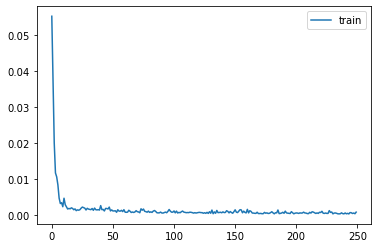

In [92]:
plt.plot(train_loss, label='train');
plt.legend();

In [93]:
unet = trained_model

In [94]:
# Evaluate the model on all datasets

unet.eval()

for group in ['train']:
    
    i=0
    track_loss = 0
    
    for batch in dataloader[group]: 
        
            data = batch['t1']['data'].to(device)
            
            with torch.no_grad():
                
                output = unet(data)
                loss = criterion(output,data)
                
                track_loss += loss.item()
                i+=1
                
    print(group, ': loss per batch = ', track_loss/i)

train : loss per batch =  0.00031451428367290646


In [95]:
# Visualize the output (train_dev and test_dev)

# Generate sample from two dev datasets
train_input = next(enumerate(dataloader['train']))

In [96]:
# Run network on samples
train_output = unet(train_input[1]['t1']['data'].to(device))

In [97]:
# Extract latent representations

#train_latent = unet.output_latent_representations(train_input[1]['t1']['data'].to(device))

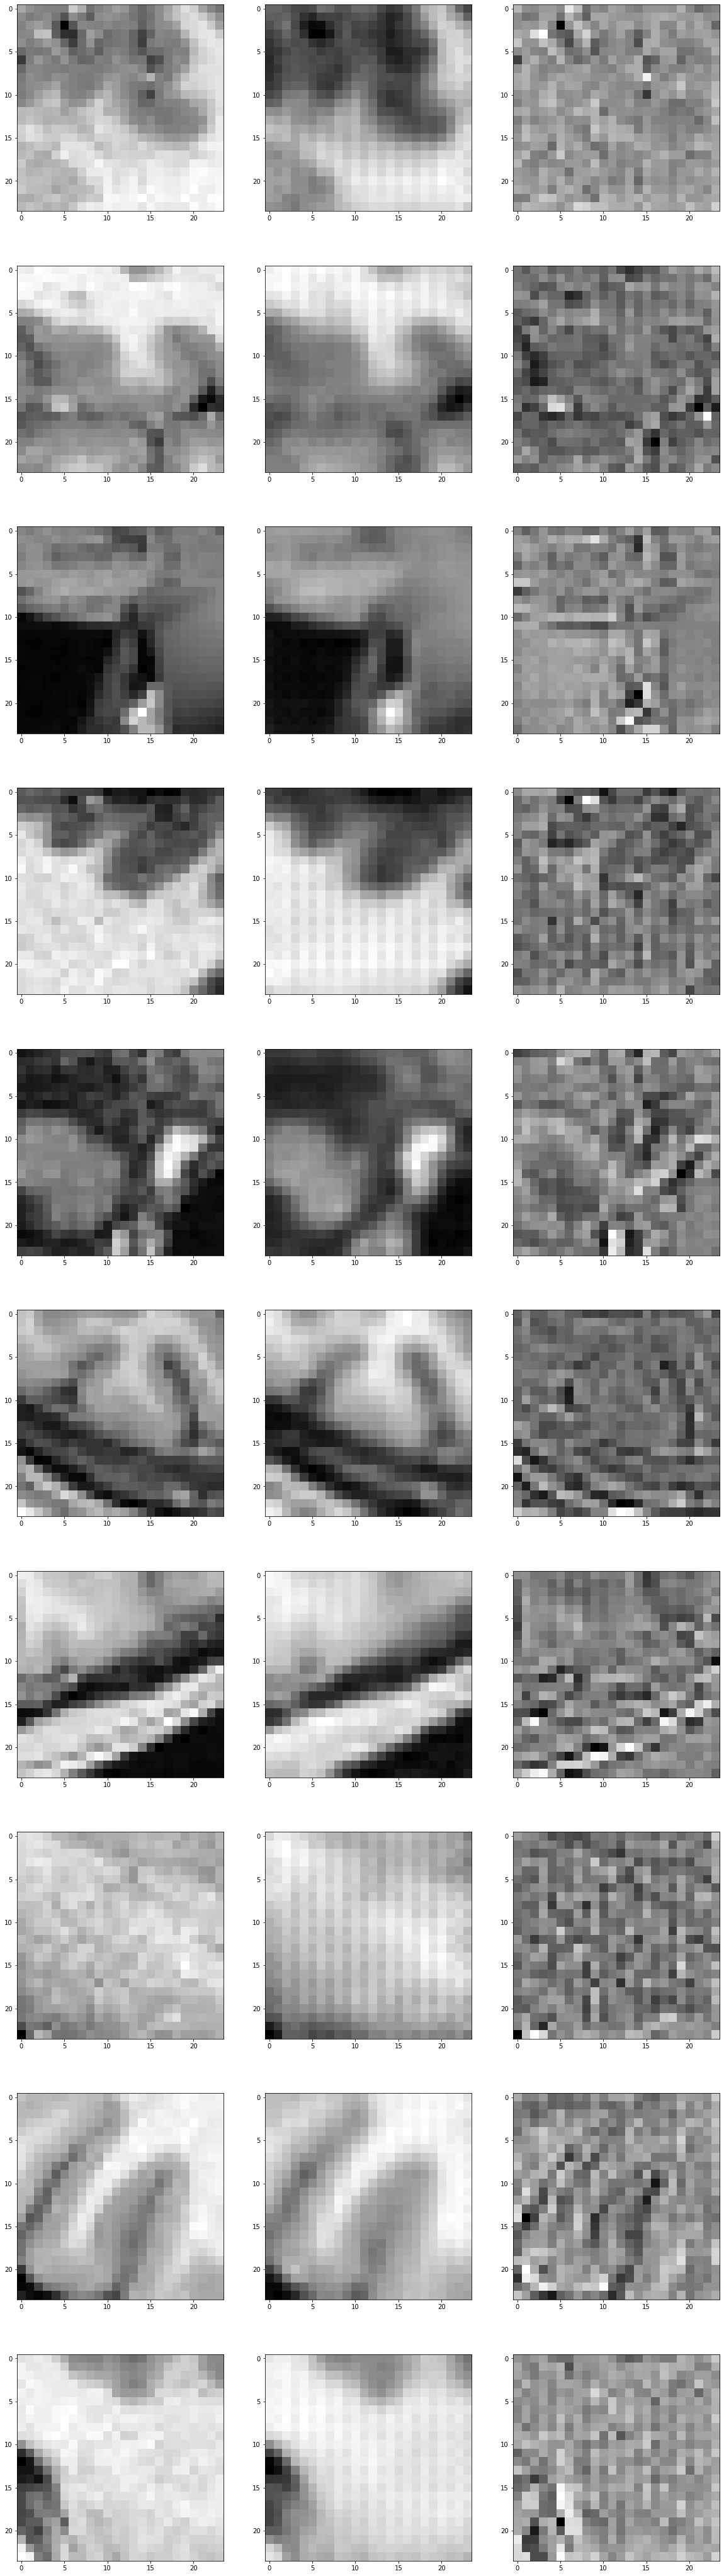

In [98]:
# Visualize train sample

inputs = train_input[1]['t1']['data'].to('cpu')
#latent = train_latent.cpu().detach().numpy()
outputs = train_output.cpu().detach().numpy()

fig = plt.figure(figsize=(20,75))

for i in range(outputs.shape[0]):
    
    plt.subplot(outputs.shape[0],3,3*i+1)
    plt.imshow(inputs[i,0,:,:,5],cmap='gray');
    
    plt.subplot(outputs.shape[0],3,3*i+2)
    plt.imshow(outputs[i,0,:,:,5], cmap ='gray')
    
    plt.subplot(outputs.shape[0],3,3*i+3)
    plt.imshow(inputs[i,0,:,:,5]-outputs[i,0,:,:,5], cmap ='gray')
    
plt.show()

# Evaluate and visualize results for chiasms


train


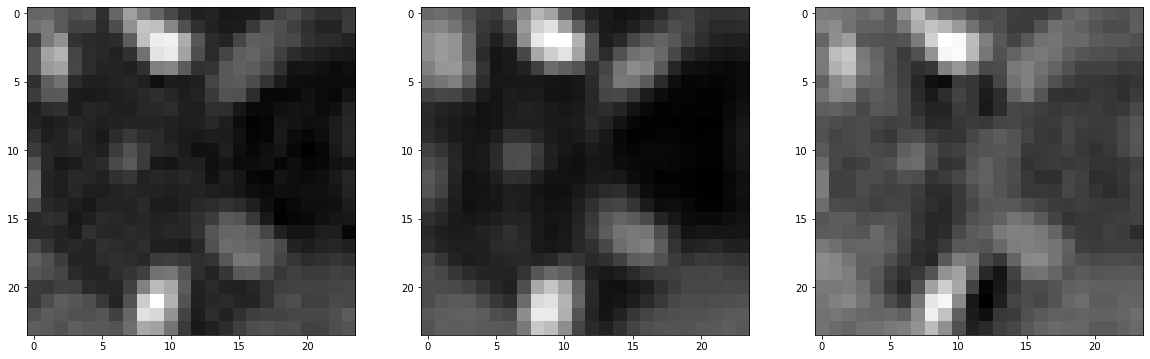

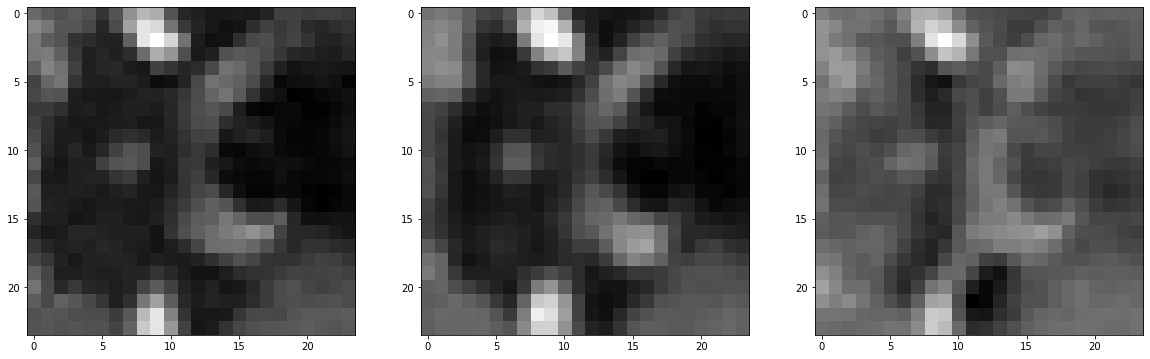

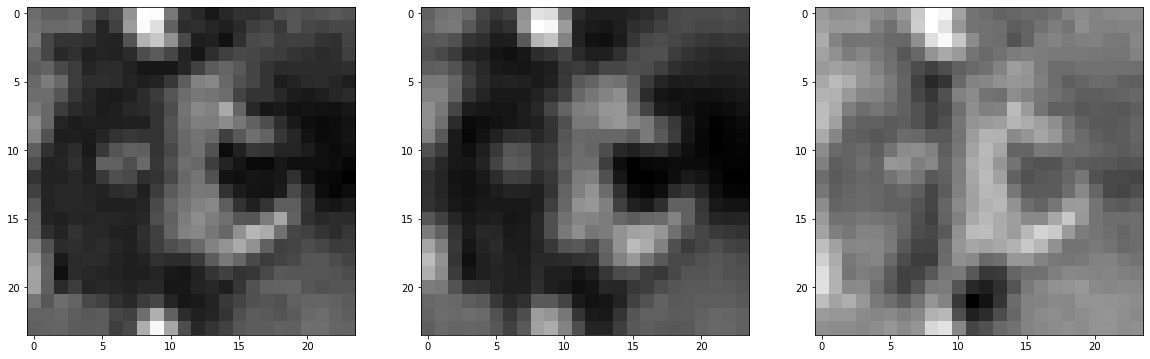

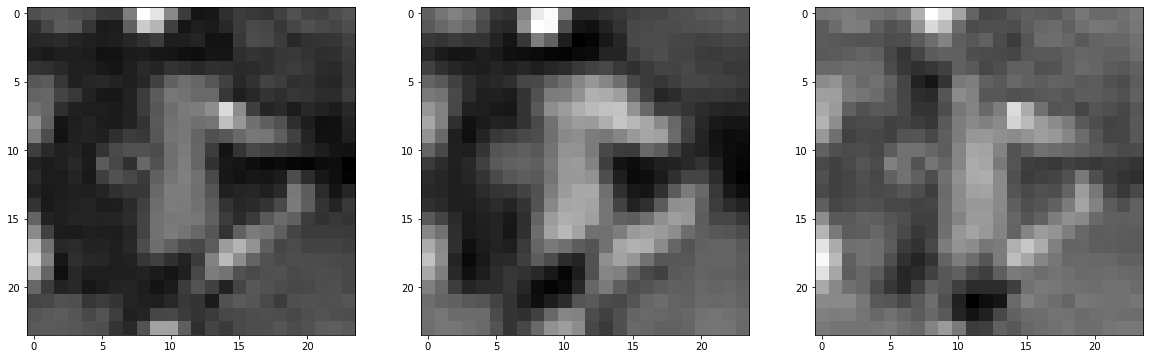

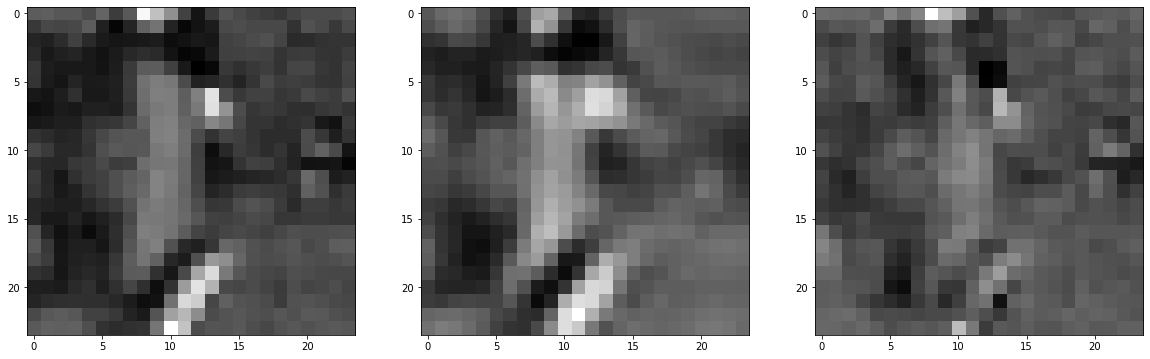

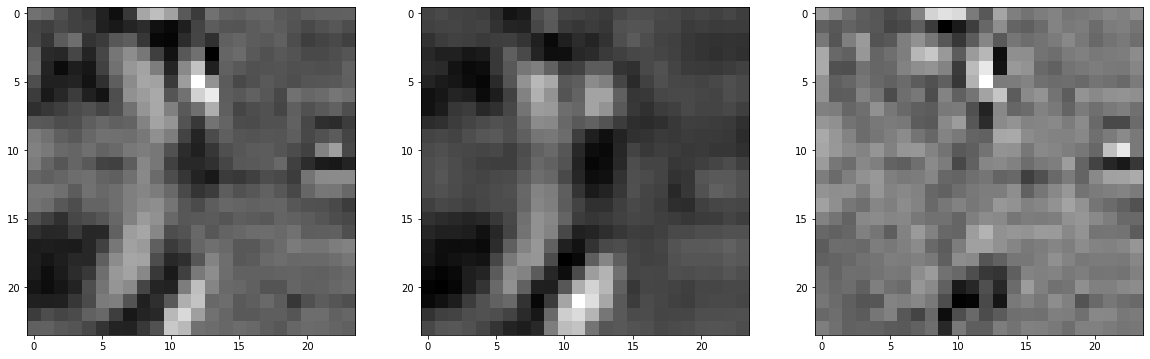

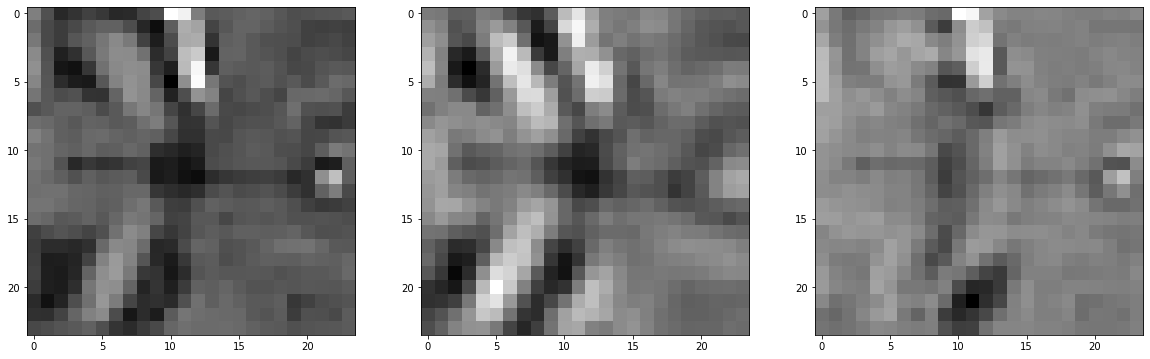

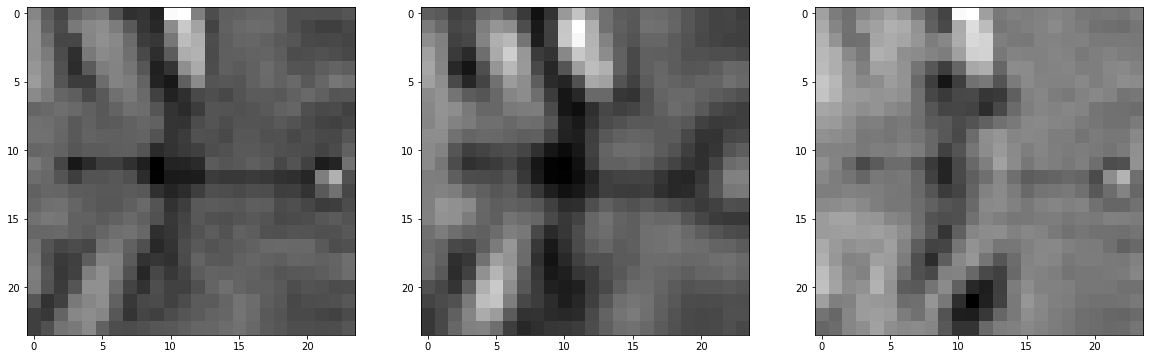

In [99]:
# Visualize results

unet.eval()

for group in ['train']:
    
    print(group)
    
    batch = next(enumerate(dataloader_chiasms[group]))
    
    data = batch[1]['t1']['data']
    
    output = unet(data.to(device))
    
    inputs = data.cpu().numpy()
    outputs = output.cpu().detach().numpy()   
    
    for i in range(outputs.shape[0]):
        for j in range(8):
            
            fig = plt.figure(figsize=(20,20))
        
            plt.subplot(outputs.shape[0],3,3*i+1)
            plt.imshow(inputs[i,0,:,:,j],cmap='gray');

            plt.subplot(outputs.shape[0],3,3*i+2)
            plt.imshow(outputs[i,0,:,:,j],cmap='gray');

            plt.subplot(outputs.shape[0],3,3*i+3)
            plt.imshow(inputs[i,0,:,:,j]-outputs[i,0,:,:,5],cmap='gray');
    
    
            plt.show()

In [100]:
batch = next(enumerate(dataloader_chiasms['train']))
print(batch[1]['t1']['data'].shape)

torch.Size([1, 1, 24, 24, 8])
